In [1]:
import pandas as pd
from sqlalchemy import create_engine
from catboost import CatBoostClassifier
import pickle
import numpy as np
from matplotlib import pyplot as plt

connect = create_engine("postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml")

In [2]:
users = pd.read_sql('''SELECT * 
                 FROM user_data u
                 ''', connect, index_col='user_id')

In [3]:
posts = pd.read_sql('''SELECT * 
                 FROM post_text_df p
                 ''', connect, index_col='post_id')

In [4]:
import time
start_time = time.time()
df = pd.read_sql('''select t.*
                        from (select f.*
                                ,row_number() over (partition by user_id order by random()) as seqnum
                                ,count(*) over () as cnt
                                ,count(*) over (partition by user_id) as cc_cnt
                              from feed_data f
                              where action = 'view'
                             ) t
                        where seqnum <= cc_cnt*(cc_cnt/(cnt*0.001)) + 1''', connect)
print("--- %s sec ---" % (time.time() - start_time))
#cnt*0.0001 - 4794602 rows - 818 sec
#cnt*0.001 - 406541 rows - 284 sec

--- 332.10764813423157 sec ---


In [5]:
df.head(1)

,timestamp,user_id,post_id,action,target,seqnum,cnt,cc_cnt
0,2021-12-24 14:11:10,200,2979,view,0,1,68686455,358


In [6]:
# list_cities = list(users['city'].unique())

In [7]:
# from sklearn.feature_extraction.text import CountVectorizer
# cv = CountVectorizer(ngram_range=(1, 3), max_features=400)
# see_vect = cv.fit_transform(list_cities)

In [8]:
# bag_of_cities = cv.transform(users['city'])

In [9]:
# user_ids = users.index.tolist()
# users_bags = pd.DataFrame.sparse.from_spmatrix(bag_of_cities)
# users_bags.index = user_ids
# users_bags.index.names = ['user_id']

In [10]:
# users_full = pd.concat([users, users_bags], axis=1).drop(['city'], axis=1)

In [11]:
users_full = users.copy()

In [12]:
users_full.to_csv('users_full.csv')
users_new = pd.read_csv('users_full.csv', index_col='user_id')  

In [13]:
users_new.to_sql('users_bags_om', connect, if_exists='replace', index = True)

205

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=500)

item_ids = posts.index.tolist()
tfidf_matrix = vectorizer.fit_transform(posts['text'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

/Users/olgamorozova/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<7023x500 sparse matrix of type '<class 'numpy.float64'>'
	with 403540 stored elements in Compressed Sparse Row format>

In [15]:
posts_tf_idf = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix)
posts_tf_idf.index = item_ids
posts_tf_idf.index.names = ['post_id']

In [16]:
posts_full = pd.concat([posts, posts_tf_idf], axis=1)

In [17]:
posts_tf_idf.head(1)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
post_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.241532,0.08494,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.109045,0.113818,0.0,0.0,0.0,0.0


In [18]:
posts_full.to_csv('posts_full.csv')
posts_new = pd.read_csv('posts_full.csv', index_col='post_id')  

In [19]:
posts_new.to_sql('posts_tf_idf_om', connect, if_exists='replace', index = True)

23

In [20]:
df = df.merge(users_new, how='inner', on='user_id')
# df = df.merge(posts, how='inner', on='post_id')
df = df.merge(posts_new, how='inner', on='post_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569746 entries, 0 to 569745
Columns: 517 entries, timestamp to 499
dtypes: datetime64[ns](1), float64(500), int64(9), object(7)
memory usage: 2.2+ GB


In [21]:
df.head(1)

,timestamp,user_id,post_id,action,target,seqnum,cnt,cc_cnt,gender,age,...,490,491,492,493,494,495,496,497,498,499
0,2021-12-24 14:11:10,200,2979,view,0,1,68686455,358,1,34,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
df.timestamp

0        2021-12-24 14:11:10
1        2021-11-30 09:56:11
2        2021-11-01 07:16:07
3        2021-10-25 08:11:48
4        2021-10-18 06:41:23
                 ...        
569741   2021-10-31 15:30:18
569742   2021-11-29 15:55:01
569743   2021-11-08 06:56:33
569744   2021-11-11 12:15:11
569745   2021-11-27 19:54:17
Name: timestamp, Length: 569746, dtype: datetime64[ns]

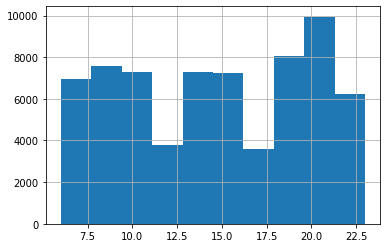

In [23]:
df['timestamp'][df['target']==1].dt.hour.hist()
plt.show()


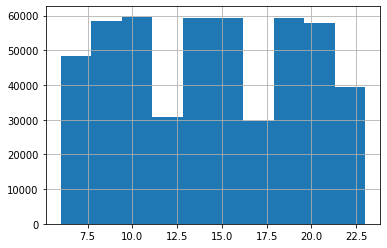

In [24]:
df['timestamp'][df['target']==0].dt.hour.hist()
plt.show()


In [25]:
def add_time_features(df, col, add_hour=False):
    new_features =  df[col].apply(lambda ts: (ts.hour >= 23) | (ts.hour <=4)).astype('int')
#     night = ((hour >= 23) | (hour <=4)).astype('int')
#     morning = ((hour >= 7) & (hour <= 11)).astype('int').values.reshape(-1, 1)
#     day = ((hour >= 12) & (hour <= 18)).astype('int').values.reshape(-1, 1)
#     evening = ((hour >= 23) & (hour <= 23)).astype('int').values.reshape(-1, 1)
#     night = ((hour >= 0) & (hour <=4)).astype('int').values.reshape(-1, 1)
    

#     if add_hour:
#         # we'll do it right and scale hour dividing by 24
#         objects_to_hstack.append(hour.values.reshape(-1, 1) / 24)
#         feature_names.append('hour')
        
#     day_of_week = times_df['time1'].apply(lambda t: t.isoweekday())
#     dummy_day = pd.get_dummies(day_of_week)
#     #mon = times_df['time1'].apply(lambda t: 1 if t.isoweekday == 1 else 0).values.reshape(-1, 1)
#     is_weekend = times_df['time1'].apply(lambda t: 1 if t.isoweekday() > 5 else 0).values.reshape(-1, 1)
#     month = times_df['time1'].apply(lambda t: t.month).values.reshape(-1, 1) 
#     #dummy_month = pd.get_dummies(month, dummy_na=True)
    
#     year = times_df['time1'].apply(lambda t: t.year)
#     dummy_year= pd.get_dummies(year)
#     # linear trend: time in a form YYYYMM, we'll divide by 1e5 to scale this feature 
#     year_month = times_df['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1) / 1e5
#     # время года
#     #winter = times['time1'].apply(lambda t: 1 if t.month in (12, 1, 2) else 0).values.reshape(-1, 1)
#     #spring = times['time1'].apply(lambda t: 1 if t.month in (3, 4, 5) else 0).values.reshape(-1, 1) 
#     #autumn = times['time1'].apply(lambda t: 1 if t.month in (9, 10, 11) else 0).values.reshape(-1, 1)#else (1 if t.month in (3, 4, 5) else (2 if t.month in (6, 7, 8) else 3))).values.reshape(-1, 1) 
#     # время посещения первого сайта
#     #print()
#     unique = times_df['unique'].values.reshape(-1, 1)
#     delta1 = (times_df[['time1', 'time2']].diff(axis=1)/ np.timedelta64(1, 's')).fillna(0).astype('int')#['time2']#.values.reshape(-1, 1) 

#     #delta = (times_df[['time1', 'time10']].diff(axis=1)/ np.timedelta64(1, 's')).fillna(0).astype('int')#.values.reshape(-1, 1)  
#     # время всей сессии
#     delta_full = (times_df[times].diff(axis=1)/ np.timedelta64(1, 's')).fillna(0).astype('int').sum(axis=1)
#     scaler = StandardScaler()
#     dur_scaled = scaler.fit_transform(delta_full.values.reshape(-1, 1))
#     dur_sc1 = scaler.fit_transform(delta1['time2'].values.reshape(-1, 1))
    
#     #delta = (times['time2'] - times['time1']).values.reshape(-1, 1)/np.timedelta64(1,'s')#
#     objects_to_hstack = [X_sparse, unique, morning, day, evening, night, dummy_day, month, is_weekend, year_month, dur_sc1, dur_scaled]#,delta]
#     feature_names = ['unique', 'morning', 'day', 'evening', 'night', 'dummy_day', 'month', 'is_weekend', 'year_month', 'dur_sc1', 'dur_scaled'] #, 'delta']
        
#     X = hstack(objects_to_hstack)
    
    return new_features

# df['timestamp']= add_time_features(df, 'timestamp')
# X_train_with_times1, new_feat_names = add_time_features(train_times, X_train_sites)
# X_test_with_times1, _ = add_time_features(test_times, X_test_sites)

In [26]:
data = df.copy()
cln_drop = ['action', 'cnt', 'seqnum', 'user_id', 'post_id', 'cc_cnt', 'text']
data = data.drop(cln_drop, axis=1)

In [27]:
# text_columns = ['text']
categorical_columns = data.loc[:,data.dtypes==object].columns.to_list()
# categorical_columns.remove(*text_columns)
categorical_columns

['country', 'city', 'os', 'source', 'topic']

In [28]:
X = data.drop('target', axis=1)
y = data['target']

In [29]:
order_col = X.columns.to_list()

In [30]:
order_col.sort()

In [31]:
X = X.reindex(columns=order_col)

In [32]:
X.head()

,0,1,10,100,101,102,103,104,105,106,...,99,age,city,country,exp_group,gender,os,source,timestamp,topic
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,34,Degtyarsk,Russia,3,1,Android,ads,2021-12-24 14:11:10,covid
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,17,Bratsk,Russia,4,1,iOS,ads,2021-11-30 09:56:11,covid
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,30,Odesa,Ukraine,0,1,Android,ads,2021-11-01 07:16:07,covid
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,34,Nizhniy Novgorod,Russia,2,1,Android,ads,2021-10-25 08:11:48,covid
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,29,Samara,Russia,1,0,Android,ads,2021-10-18 06:41:23,covid


In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

In [34]:
### Your code is here
catboost = CatBoostClassifier(random_state=1, auto_class_weights='Balanced')

catboost.fit(X_train, y_train, cat_features=categorical_columns, verbose=False, plot=True)
catboost.save_model('model_control',
                           format="cbm")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [35]:
from_file = CatBoostClassifier()  # здесь не указываем параметры, которые были при обучении, в дампе модели все есть

model = from_file.load_model("model_control")

In [36]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [37]:
test_preds = model.predict(X_test)


In [38]:
print(accuracy_score(y_test, test_preds))
print(classification_report(y_test, test_preds, digits=3))
# 0.6331285651601579
#               precision    recall  f1-score   support

#            0      0.925     0.635     0.753    100376
#            1      0.186     0.618     0.287     13574

#     accuracy                          0.633    113950
#    macro avg      0.556     0.627     0.520    113950
# weighted avg      0.837     0.633     0.698    113950


0.6204738920579201
              precision    recall  f1-score   support

           0      0.925     0.620     0.742    100361
           1      0.182     0.626     0.282     13589

    accuracy                          0.620    113950
   macro avg      0.553     0.623     0.512    113950
weighted avg      0.836     0.620     0.687    113950



In [39]:
import datetime
def get_preds_id(id, time, limit):
    user_and_posts = posts_new.drop('text', axis=1)
    user_and_posts[users_new.columns] = users_new[users_new.index == id].values[0]
    user_and_posts['timestamp'] = time
    user_and_posts['timestamp'] = user_and_posts['timestamp'].apply(lambda ts: (ts.hour >= 23) | (ts.hour <=4)).astype('int')
    order_col = user_and_posts.columns.to_list()
    order_col.sort()
    user_and_posts = user_and_posts.reindex(columns=order_col)
    user_and_posts['timestamp'] = model.predict_proba(user_and_posts)[:, 1]
    post_id_lst = user_and_posts['timestamp'].sort_values(ascending=False).index.to_list()[:limit + 1]
    return post_id_lst

In [40]:
res = get_preds_id(200, datetime.datetime.now(), 10)

In [41]:
res
#[6082, 6415, 6001, 6274, 4385, 487, 5608, 6261, 4650, 5278, 4470]


[4524, 4956, 5903, 5578, 6146, 6558, 5410, 5734, 4061, 7303, 6002]

In [42]:
show_posts_list = ['text', 'topic']
posts_new[posts_new.index.isin(res)].loc[:, show_posts_list].reindex(index=res)

,text,topic
post_id,,
4524,"A unique blend of musical, film-noir and comed...",movie
4956,This movie is important to those of us interes...,movie
5903,Paul Thomas Andersons stylish and compelling t...,movie
5578,Roy Andersson has managed to craft something t...,movie
6146,"Granted, HOTD 2 is better than the Uwe Boll cr...",movie
6558,I first saw Thief as a child which makes me al...,movie
5410,Brilliant over-acting by Lesley Ann Warren. Be...,movie
5734,I couldnt relate to this film. It failed to en...,movie
4061,Conducting entrance examinations is not like b...,covid
